In [2]:
pip install transformers torch scikit-learn matplotlib seaborn

^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from wordcloud import WordCloud

import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
import warnings
warnings.filterwarnings("ignore")

In [4]:
train_df = pd.read_csv('/kaggle/input/imdb-50k-movie-reviews-test-your-bert/train.csv')
test_df = pd.read_csv('/kaggle/input/imdb-50k-movie-reviews-test-your-bert/test.csv')

In [5]:
train_df.head()

,text,sentiment
0,"Now, I won't deny that when I purchased this o...",neg
1,"The saddest thing about this ""tribute"" is that...",neg
2,Last night I decided to watch the prequel or s...,neg
3,I have to admit that i liked the first half of...,neg
4,I was not impressed about this film especially...,neg


In [6]:
df = train_df

In [7]:
# Check for missing values
print(train_df.isnull().sum())

# Check data types and column names
print(train_df.info())

# Check the unique sentiment values
print(train_df['sentiment'].unique())

text         0
sentiment    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       25000 non-null  object
 1   sentiment  25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB
None
['neg' 'pos']


In [8]:
# Map 'neg' to 0 and 'pos' to 1 for sentiment column
train_df['sentiment'] = train_df['sentiment'].map({'neg': 0, 'pos': 1})

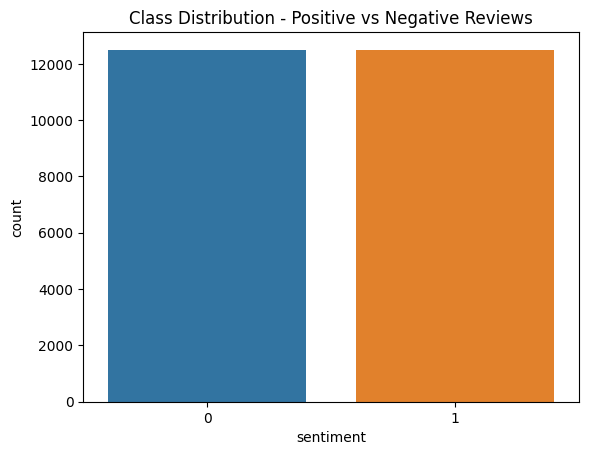

sentiment
0    50.0
1    50.0
Name: proportion, dtype: float64

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot class distribution
sns.countplot(x='sentiment', data=train_df)
plt.title('Class Distribution - Positive vs Negative Reviews')
plt.show()

# Check the percentage distribution of each sentiment
train_df['sentiment'].value_counts(normalize=True) * 100

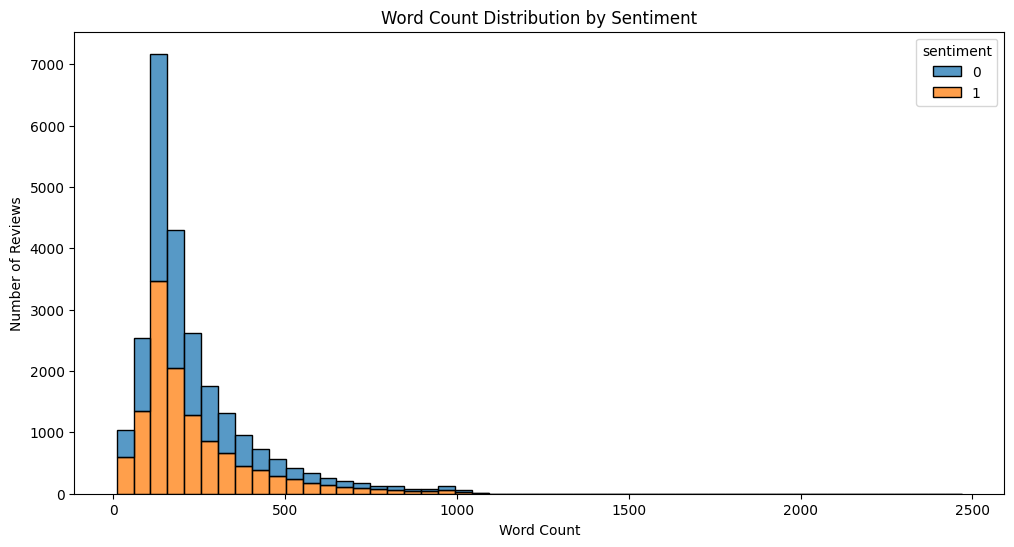

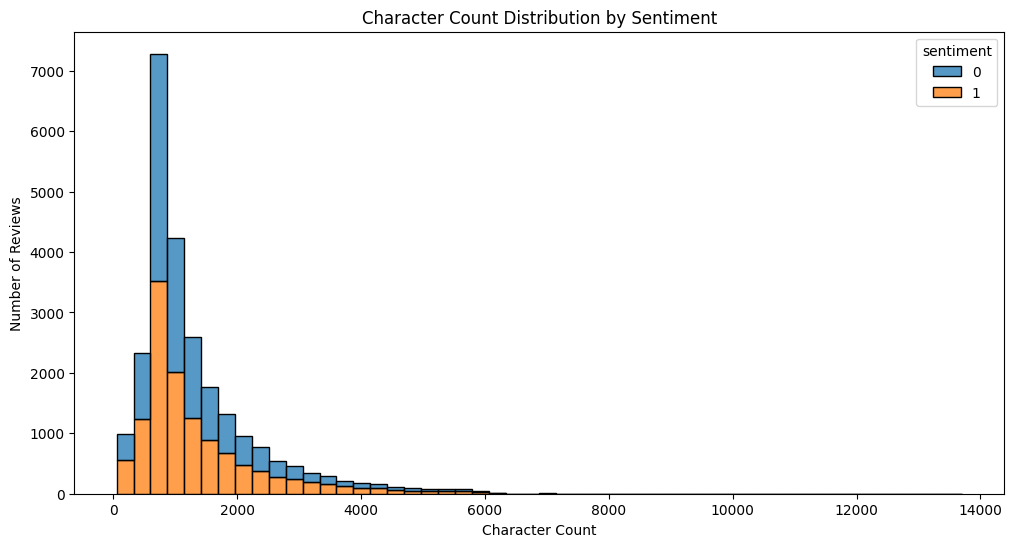

In [10]:
# Add word count and character count columns
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))
train_df['char_count'] = train_df['text'].apply(lambda x: len(x))

# Plot word count distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='word_count', hue='sentiment', multiple='stack', bins=50)
plt.title('Word Count Distribution by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Number of Reviews')
plt.show()

# Plot character count distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='char_count', hue='sentiment', multiple='stack', bins=50)
plt.title('Character Count Distribution by Sentiment')
plt.xlabel('Character Count')
plt.ylabel('Number of Reviews')
plt.show()

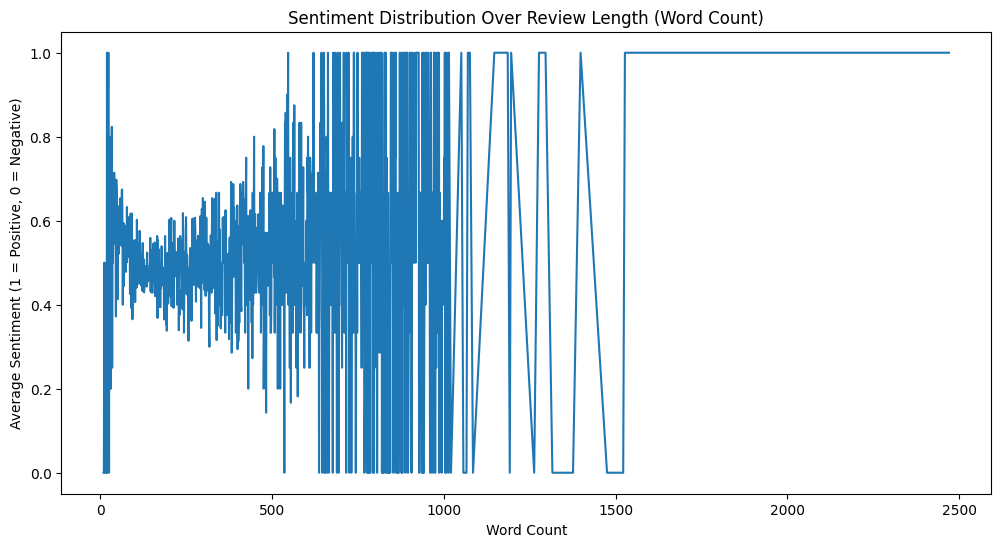

In [11]:
# Group by word count and calculate the mean sentiment
word_count_sentiment = train_df.groupby('word_count')['sentiment'].mean()

# Plot sentiment distribution over word count
plt.figure(figsize=(12, 6))
sns.lineplot(x=word_count_sentiment.index, y=word_count_sentiment.values)
plt.title('Sentiment Distribution Over Review Length (Word Count)')
plt.xlabel('Word Count')
plt.ylabel('Average Sentiment (1 = Positive, 0 = Negative)')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter
import string

# Function to clean text and remove stopwords and punctuation
def clean_text(text):
    text = text.lower()
    words = text.split()
    words = [word for word in words if word not in ENGLISH_STOP_WORDS and word not in string.punctuation]
    return words

# Get word frequencies for positive and negative reviews
positive_words = clean_text(' '.join(train_df[train_df['sentiment'] == 1]['text']))
negative_words = clean_text(' '.join(train_df[train_df['sentiment'] == 0]['text']))

# Plot top 20 most common words in positive reviews
positive_word_freq = Counter(positive_words)
most_common_positive = positive_word_freq.most_common(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[1] for word in most_common_positive], y=[word[0] for word in most_common_positive])
plt.title('Top 20 Most Common Words in Positive Reviews')
plt.show()

# Plot top 20 most common words in negative reviews
negative_word_freq = Counter(negative_words)
most_common_negative = negative_word_freq.most_common(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[1] for word in most_common_negative], y=[word[0] for word in most_common_negative])
plt.title('Top 20 Most Common Words in Negative Reviews')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Function to get n-grams
def get_top_n_grams(corpus, ngram_range=(2, 2), n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Top 10 bigrams for positive reviews
top_positive_bigrams = get_top_n_grams(train_df[train_df['sentiment'] == 1]['text'], ngram_range=(2, 2), n=10)
top_negative_bigrams = get_top_n_grams(train_df[train_df['sentiment'] == 0]['text'], ngram_range=(2, 2), n=10)

# Plot positive bigrams
plt.figure(figsize=(10, 6))
sns.barplot(x=[word[1] for word in top_positive_bigrams], y=[word[0] for word in top_positive_bigrams])
plt.title('Top 10 Bigrams in Positive Reviews')
plt.show()

# Plot negative bigrams
plt.figure(figsize=(10, 6))
sns.barplot(x=[word[1] for word in top_negative_bigrams], y=[word[0] for word in top_negative_bigrams])
plt.title('Top 10 Bigrams in Negative Reviews')
plt.show()

In [ ]:
# Word count distribution for positive and negative reviews
plt.figure(figsize=(12, 6))
sns.histplot(train_df[train_df['sentiment'] == 1]['word_count'], color='green', bins=50, label='Positive', kde=True)
sns.histplot(train_df[train_df['sentiment'] == 0]['word_count'], color='red', bins=50, label='Negative', kde=True)
plt.title('Word Count Distribution for Positive vs Negative Reviews')
plt.xlabel('Word Count')
plt.ylabel('Number of Reviews')
plt.legend()
plt.show()

# Character count distribution for positive and negative reviews
plt.figure(figsize=(12, 6))
sns.histplot(train_df[train_df['sentiment'] == 1]['char_count'], color='green', bins=50, label='Positive', kde=True)
sns.histplot(train_df[train_df['sentiment'] == 0]['char_count'], color='red', bins=50, label='Negative', kde=True)
plt.title('Character Count Distribution for Positive vs Negative Reviews')
plt.xlabel('Character Count')
plt.ylabel('Number of Reviews')
plt.legend()
plt.show()

In [ ]:
# Create a set of words for positive and negative reviews
positive_words_set = set(positive_words)
negative_words_set = set(negative_words)

# Words common to both positive and negative reviews
common_words = positive_words_set.intersection(negative_words_set)

# Words unique to positive reviews
unique_positive_words = positive_words_set - common_words

# Words unique to negative reviews
unique_negative_words = negative_words_set - common_words

print(f"Number of common words between positive and negative reviews: {len(common_words)}")
print(f"Number of unique words in positive reviews: {len(unique_positive_words)}")
print(f"Number of unique words in negative reviews: {len(unique_negative_words)}")

In [ ]:
# Plot most common shared words between positive and negative reviews
common_word_freq = Counter(common_words)
most_common_shared = common_word_freq.most_common(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[1] for word in most_common_shared], y=[word[0] for word in most_common_shared])
plt.title('Top 20 Most Common Words Shared Between Positive and Negative Reviews')
plt.show()

In [ ]:
# Function to count specific punctuation marks
def count_punctuation(text, punct):
    return text.count(punct)

# Add columns for punctuation counts
train_df['exclamation_count'] = train_df['text'].apply(lambda x: count_punctuation(x, '!'))
train_df['question_count'] = train_df['text'].apply(lambda x: count_punctuation(x, '?'))
train_df['ellipsis_count'] = train_df['text'].apply(lambda x: count_punctuation(x, '...'))

# Plot the distribution of exclamation marks
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='exclamation_count', hue='sentiment', multiple='stack', bins=30)
plt.title('Exclamation Mark (!) Distribution by Sentiment')
plt.xlabel('Number of Exclamation Marks')
plt.ylabel('Number of Reviews')
plt.show()

# Plot the distribution of question marks
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='question_count', hue='sentiment', multiple='stack', bins=30)
plt.title('Question Mark (?) Distribution by Sentiment')
plt.xlabel('Number of Question Marks')
plt.ylabel('Number of Reviews')
plt.show()

# Plot the distribution of ellipses (…)
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='ellipsis_count', hue='sentiment', multiple='stack', bins=30)
plt.title('Ellipsis (...) Distribution by Sentiment')
plt.xlabel('Number of Ellipses')
plt.ylabel('Number of Reviews')
plt.show()

In [ ]:
# Import WordCloud library
from wordcloud import WordCloud

# Generate word cloud for positive reviews
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_words))

# Plot the word cloud for positive reviews
plt.figure(figsize=(10, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.show()

# Generate word cloud for negative reviews
negative_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(negative_words))

# Plot the word cloud for negative reviews
plt.figure(figsize=(10, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')
plt.show()

In [ ]:
from textblob import TextBlob

# Function to calculate polarity and subjectivity
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Add polarity and subjectivity columns to the dataframe
train_df['polarity'] = train_df['text'].apply(get_polarity)
train_df['subjectivity'] = train_df['text'].apply(get_subjectivity)

# Visualize polarity distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='polarity', hue='sentiment', multiple='stack', bins=50, kde=True)
plt.title('Polarity Distribution by Sentiment')
plt.xlabel('Polarity')
plt.ylabel('Number of Reviews')
plt.show()

# Visualize subjectivity distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='subjectivity', hue='sentiment', multiple='stack', bins=50, kde=True)
plt.title('Subjectivity Distribution by Sentiment')
plt.xlabel('Subjectivity')
plt.ylabel('Number of Reviews')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Separate positive and negative reviews
positive_reviews = train_df[train_df['sentiment'] == 1]['text']
negative_reviews = train_df[train_df['sentiment'] == 0]['text']

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# Fit TF-IDF on both positive and negative reviews
tfidf_positive = tfidf.fit_transform(positive_reviews)
tfidf_negative = tfidf.fit_transform(negative_reviews)

# Get the top 20 words by TF-IDF score for both sentiments
positive_top_words = pd.DataFrame(tfidf_positive.toarray(), columns=tfidf.get_feature_names_out()).mean().sort_values(ascending=False)[:20]
negative_top_words = pd.DataFrame(tfidf_negative.toarray(), columns=tfidf.get_feature_names_out()).mean().sort_values(ascending=False)[:20]

# Plot top TF-IDF words for positive reviews
plt.figure(figsize=(10, 6))
sns.barplot(x=positive_top_words.values, y=positive_top_words.index)
plt.title('Top 20 TF-IDF Words in Positive Reviews')
plt.show()

# Plot top TF-IDF words for negative reviews
plt.figure(figsize=(10, 6))
sns.barplot(x=negative_top_words.values, y=negative_top_words.index)
plt.title('Top 20 TF-IDF Words in Negative Reviews')
plt.show()

In [ ]:
!pip install transformers
!pip install torch
!pip install sklearn

In [ ]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm.notebook import tqdm

In [ ]:
# Load the dataset
train_df = pd.read_csv('/kaggle/input/imdb-50k-movie-reviews-test-your-bert/train.csv')
test_df = pd.read_csv('/kaggle/input/imdb-50k-movie-reviews-test-your-bert/test.csv')

# Let's map sentiment values: "pos" = 1, "neg" = 0
train_df['sentiment'] = train_df['sentiment'].map({'pos': 1, 'neg': 0})
test_df['sentiment'] = test_df['sentiment'].map({'pos': 1, 'neg': 0})

# Split the training data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'].values, train_df['sentiment'].values, test_size=0.2, random_state=42
)

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the data for BERT
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(test_df['text'].values), truncation=True, padding=True, max_length=512)

In [ ]:
class IMDbDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create PyTorch datasets for training, validation, and testing
train_dataset = IMDbDataset(train_encodings, train_labels)
val_dataset = IMDbDataset(val_encodings, val_labels)
test_dataset = IMDbDataset(test_encodings, test_df['sentiment'].values)

In [ ]:
class IMDbDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create PyTorch datasets for training, validation, and testing
train_dataset = IMDbDataset(train_encodings, train_labels)
val_dataset = IMDbDataset(val_encodings, val_labels)
test_dataset = IMDbDataset(test_encodings, test_df['sentiment'].values)

In [ ]:
# Load the BERT model for sequence classification (binary classification)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

In [ ]:
# Define the data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Move the model to the GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

In [ ]:
# Training function
def train(model, train_loader, val_loader, optimizer, device, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(train_loader):
            # Move the batch to the correct device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Clear previously calculated gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            # Backward pass to calculate the gradients
            loss.backward()

            # Update weights
            optimizer.step()

        print(f'Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}')

        # Validate the model after each epoch
        evaluate(model, val_loader, device)

# Evaluation function
def evaluate(model, val_loader, device):
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, preds)
    print(f'Validation Accuracy: {accuracy}')
    print(classification_report(true_labels, preds))

# Train the model
train(model, train_loader, val_loader, optimizer, device, epochs=3)